In [532]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

# Analysis of Real Estate Data

In [533]:
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

In [534]:
rent_df['living_area'] = rent_df['living_area'].astype(np.float64)
rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df['lot_area'] = rent_df['lot_area'].astype(np.float64)
rent_df['area'] = rent_df['area'].astype(np.float64)
rent_df['beds'] = rent_df['beds'].astype(np.float64)
rent_df['baths'] = rent_df['baths'].astype(np.float64)
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id'], axis=1)

The structure of the data is:

In [535]:
rent_df

,date,event_description,price,address_city,zip_code,area,status_type,home_type,beds,baths,living_area,lot_area,borough
0,2021-04-16,Listed for rent,1500,Maspeth,11378.0,NaN,FOR_RENT,APARTMENT,1.0,1.0,NaN,NaN,queens
1,2021-03-03,Price change,1300,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
2,2021-02-17,Listed for rent,1350,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
3,2021-04-10,Listed for rent,3000,Maspeth,11378.0,NaN,FOR_RENT,MULTI_FAMILY,3.0,1.0,NaN,NaN,queens
4,2021-03-23,Listed for rent,3200,Flushing,11378.0,3000.0,FOR_RENT,SINGLE_FAMILY,3.0,2.5,3000.0,2500.0,queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48316,2021-03-13,No price history,2500,Bayside,11361.0,1100.0,FOR_RENT,APARTMENT,3.0,1.5,1100.0,NaN,queens
48317,2021-03-12,No price history,2400,Bayside,11361.0,NaN,FOR_RENT,APARTMENT,4.0,2.0,NaN,NaN,queens
48318,2021-02-01,No price history,2299,Bayside,11361.0,1000.0,FOR_RENT,MULTI_FAMILY,3.0,2.0,1000.0,NaN,queens
48319,2021-01-04,No price history,2274,Bayside,11361.0,NaN,FOR_RENT,MULTI_FAMILY,1.0,1.0,NaN,NaN,queens


Our analysis starts from 06/01/2019 so we need to remove the properties with a date
before 06/01/2019

In [536]:
start = datetime.datetime(2019, 6, 1)
end = datetime.datetime(2021, 4, 1)
rent_df = rent_df[(rent_df['date'] >= start) & (rent_df['date'] <= end)]

We divide the data into boroughs to analyze them individually

In [537]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

# Time Series Analysis on Manhattan

In [538]:
manhattan_df = rent_ny['manhattan']
print(manhattan_df['price'].describe())

count    12620.000000
mean      3494.927258
std       2179.796099
min        500.000000
25%       2075.000000
50%       2700.000000
75%       3995.000000
max      15000.000000
Name: price, dtype: float64


Remove outliers from the data

In [539]:
manhattan_df.drop(manhattan_df[manhattan_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [540]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
idx = pd.date_range(start, end)
manhattan_ts = manhattan_df.groupby(manhattan_df.date)['price'].agg(['mean','count', 'median'])
manhattan_ts.index = pd.DatetimeIndex(manhattan_ts.index)
manhattan_ts = manhattan_ts.reindex(idx)
manhattan_ts

,mean,count,median
2019-06-01,3200.000000,1.0,3200.0
2019-06-02,NaN,NaN,NaN
2019-06-03,4247.500000,2.0,4247.5
2019-06-04,2800.000000,1.0,2800.0
2019-06-05,3721.000000,3.0,2850.0
...,...,...,...
2021-03-28,2895.207048,227.0,2500.0
2021-03-29,2885.548822,297.0,2500.0
2021-03-30,2941.651297,347.0,2600.0
2021-03-31,2841.966245,237.0,2500.0


Plot of the raw time series for Manhattan

<AxesSubplot:>

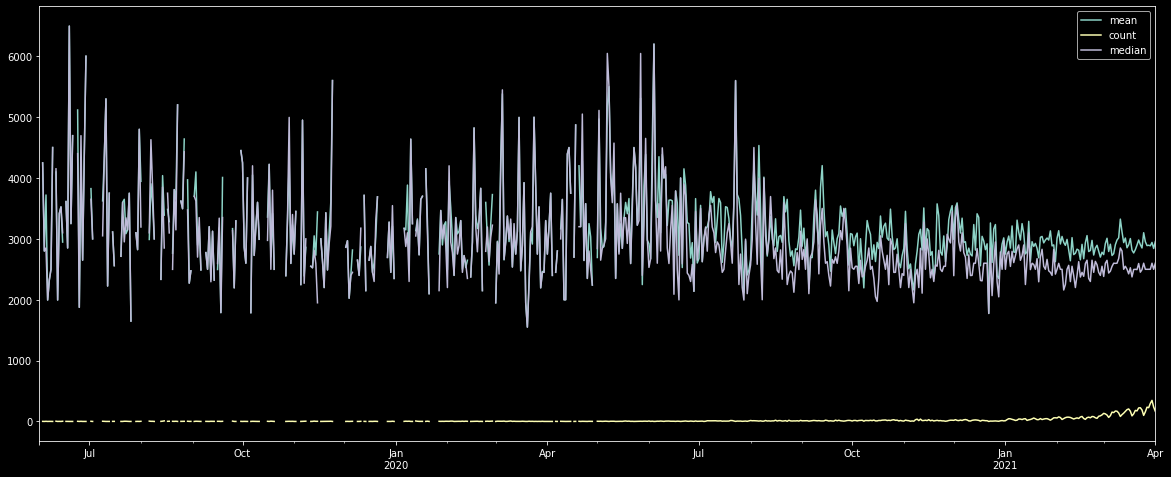

In [541]:
manhattan_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [542]:
manhattan_ts = manhattan_ts.interpolate(method='spline', order=2)


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

Comparison between different smoothing options:

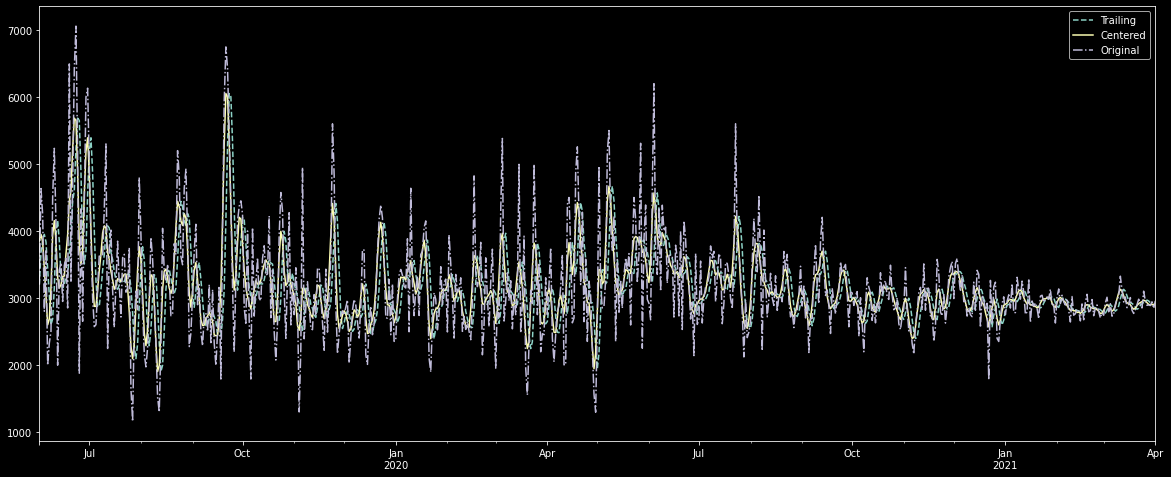

In [543]:
fig, ax = plt.subplots()
smoothed_df_trailing = manhattan_ts['mean'].rolling(5, win_type='triang', min_periods=1).mean()
smoothed_df_trailing.plot(style='--', legend=True, ax=ax)
smoothed_df_centered = manhattan_ts['mean'].rolling(5, win_type='triang', min_periods=1, center=True).mean()
smoothed_df_centered.plot(legend=True, ax=ax)
smoothed_df_not_smoothed = manhattan_ts['mean']
smoothed_df_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])

We might need to use a trailing window because we are trying to forecast into the future.

<AxesSubplot:>

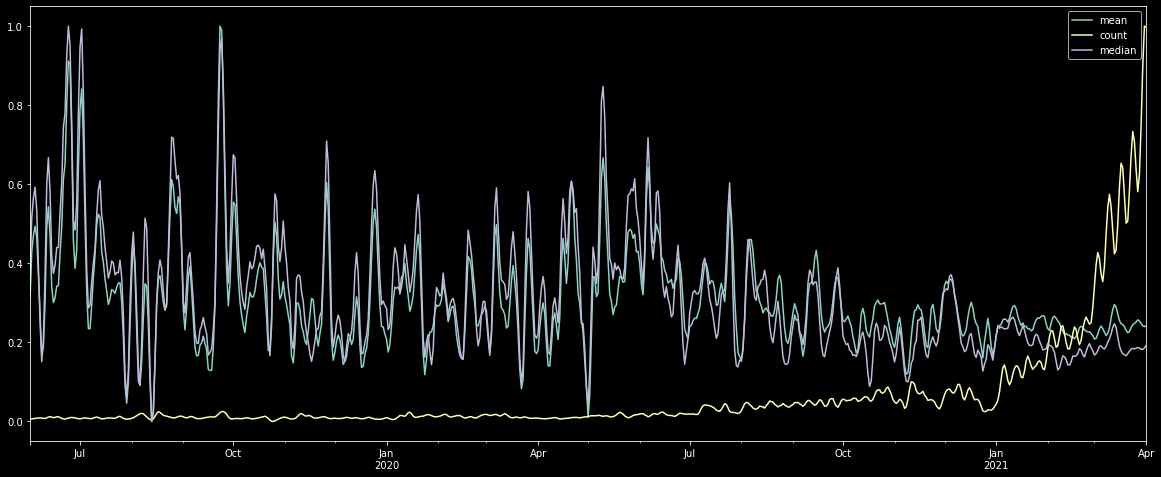

In [544]:
scaler = MinMaxScaler()
smoothed_df = manhattan_ts.rolling(5, win_type='triang', min_periods=1).mean()
smoothed_df = pd.DataFrame(scaler.fit_transform(smoothed_df), index=smoothed_df.index, columns=smoothed_df.columns)
smoothed_df.plot()

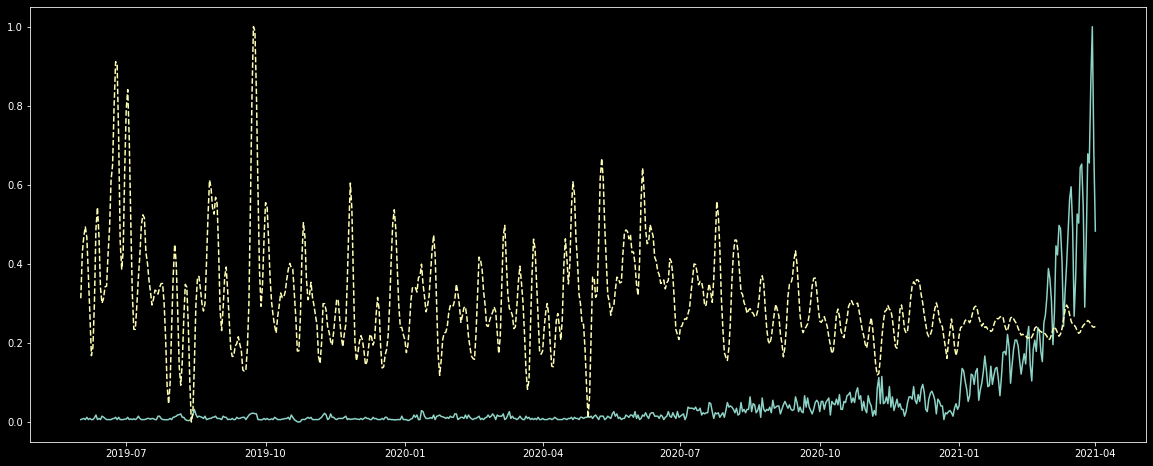

In [545]:
plt.plot(manhattan_ts.index, scaler.fit_transform(manhattan_ts[['count']]))
plt.plot(smoothed_df.index, smoothed_df['mean'], ls='--')
plt.show()

We now explore the price/sqr_feet instead of just the price.

In [546]:
price_sqft = manhattan_df[~manhattan_df['area'].isna()].sort_values('date')
price_sqft['price_per_area'] = price_sqft['price']/price_sqft['area']

<AxesSubplot:xlabel='date'>

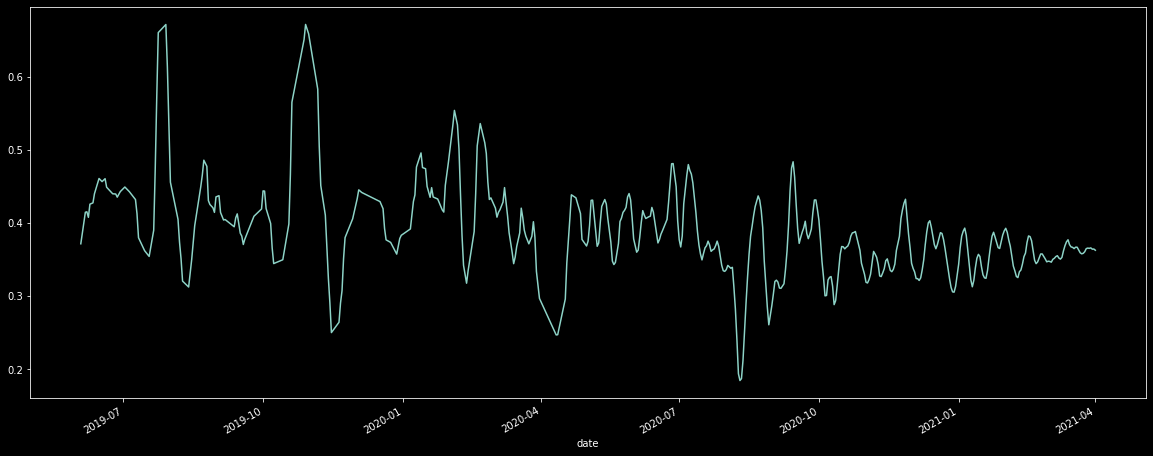

In [547]:
modified_manhattan_ts = price_sqft.groupby(price_sqft.date)['price_per_area'].agg(['mean', 'max', 'min', 'median'])
modified_manhattan_ts = modified_manhattan_ts.interpolate(method='spline', order=2)
modified_manhattan_ts = pd.DataFrame(scaler.fit_transform(modified_manhattan_ts), index=modified_manhattan_ts.index, 
                                     columns=modified_manhattan_ts.columns)
modified_manhattan_ts = modified_manhattan_ts.rolling(7, win_type='triang', min_periods=1).mean()
modified_manhattan_ts['mean'].plot()

# Introducing COVID data

In [548]:
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_df = nyc_covid_df.set_index('date', drop=True)

Covid raw data: 

<AxesSubplot:xlabel='date'>

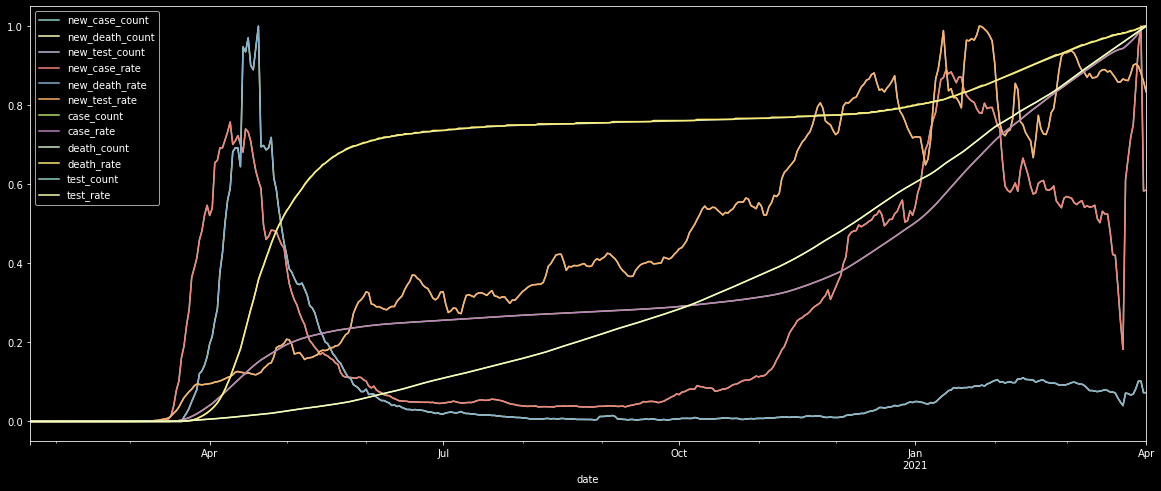

In [549]:
nyc_covid_df = pd.DataFrame(scaler.fit_transform(nyc_covid_df), columns=nyc_covid_df.columns, index=nyc_covid_df.index)
nyc_covid_df.plot()


In [550]:
new_case_rate = nyc_covid_df['new_case_rate'].rolling(7, win_type='triang', min_periods=1).mean()
case_rate = nyc_covid_df['case_rate'].rolling(7, win_type='triang', min_periods=1).mean()

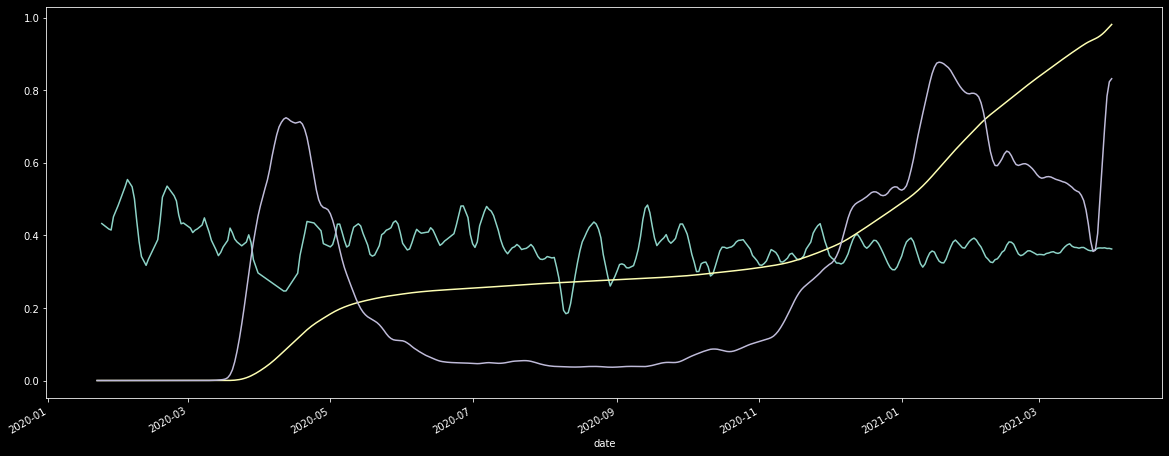

In [551]:
plt.figure()
modified_manhattan_ts[modified_manhattan_ts.index >= case_rate.index.min()]['mean'].plot()
case_rate.plot()
new_case_rate.plot()
plt.show()

# Seasonal Decompositions

Decomposition is the process of understanding generalizations and problems related to time-series forecasting. 
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

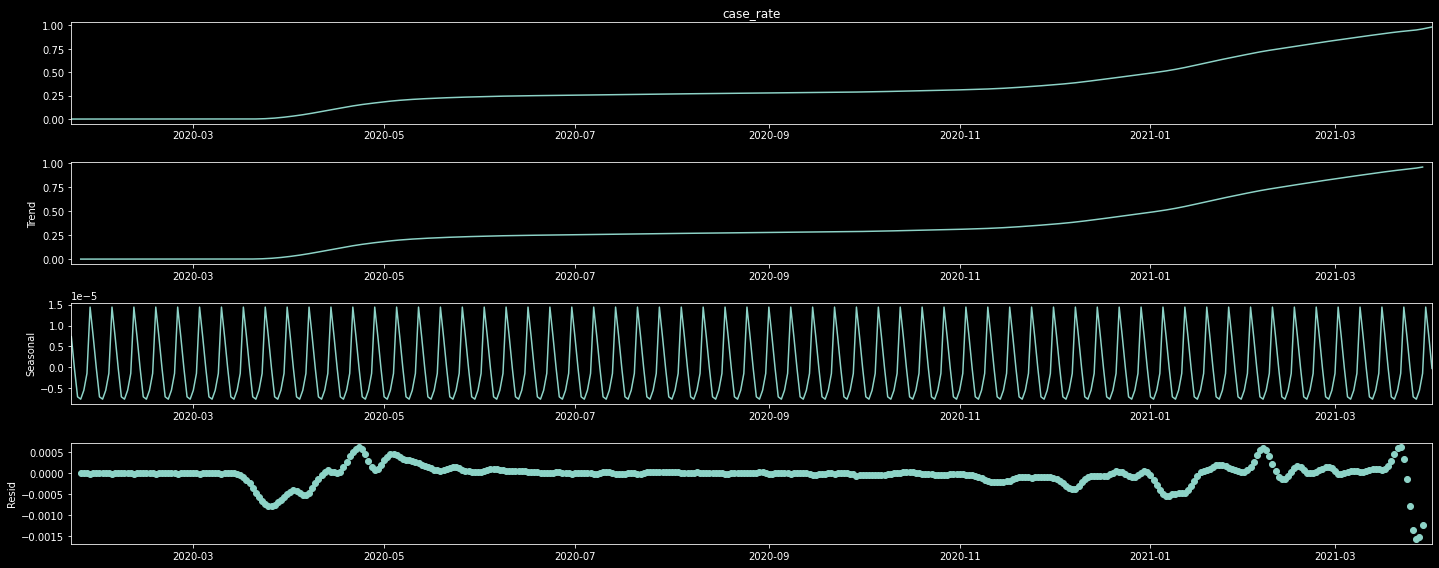

In [552]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_covid = seasonal_decompose(case_rate.drop(case_rate[case_rate.isna()].index), model='additive')
result_covid.plot()
plt.show()

<AxesSubplot:>

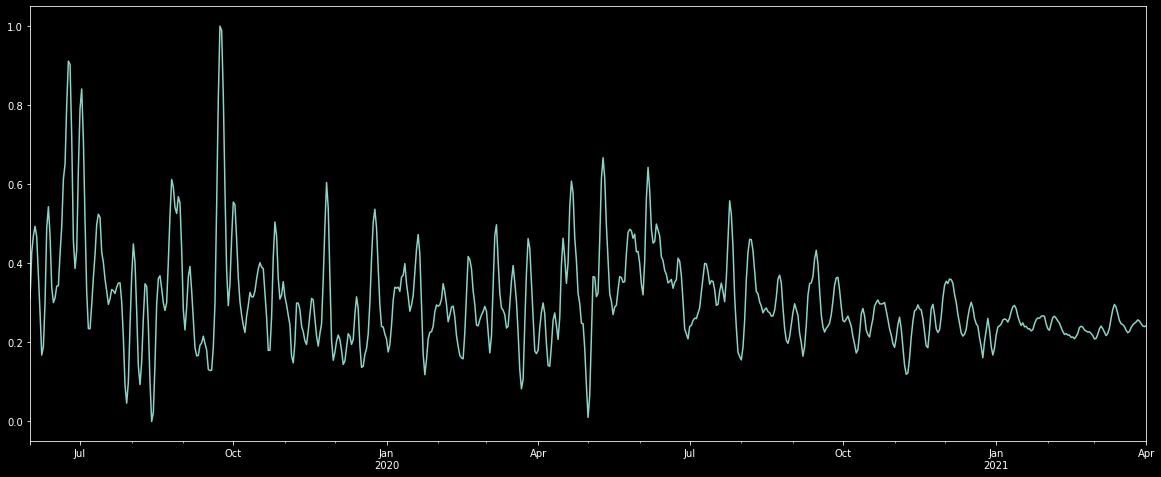

In [553]:
smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index).plot()

In [554]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_price = seasonal_decompose(smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index), model='additive')

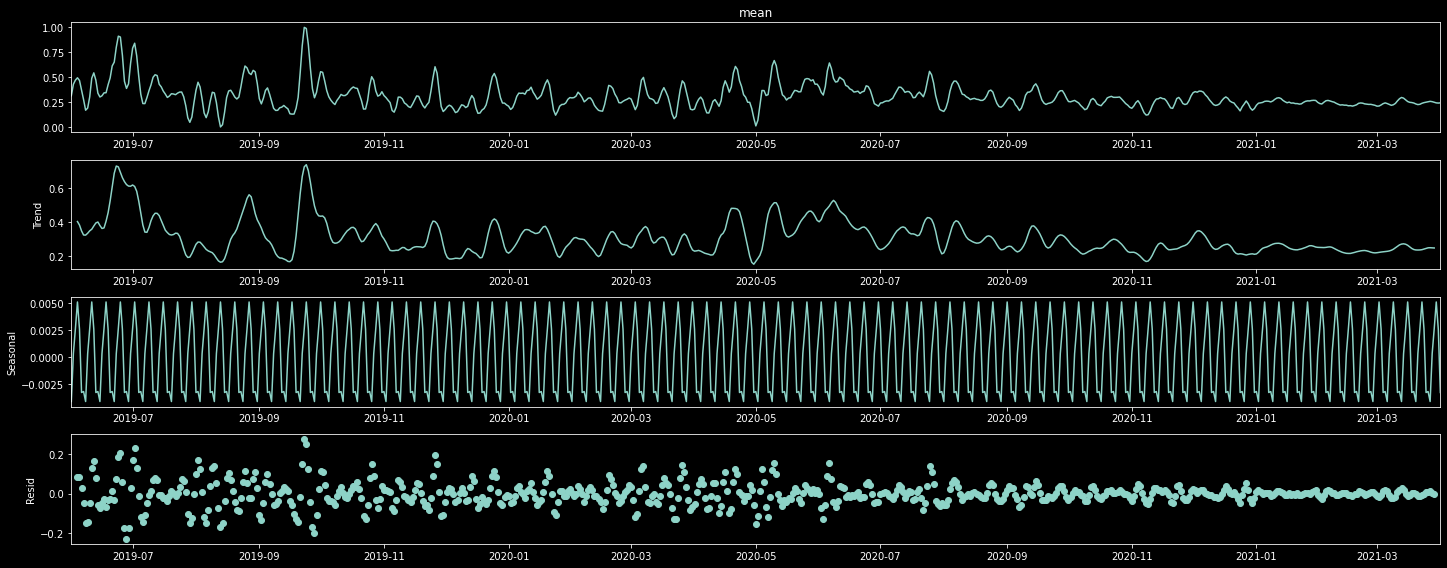

In [555]:
result_price.plot()
plt.show()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

covid case rate autocorrelation plot:

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

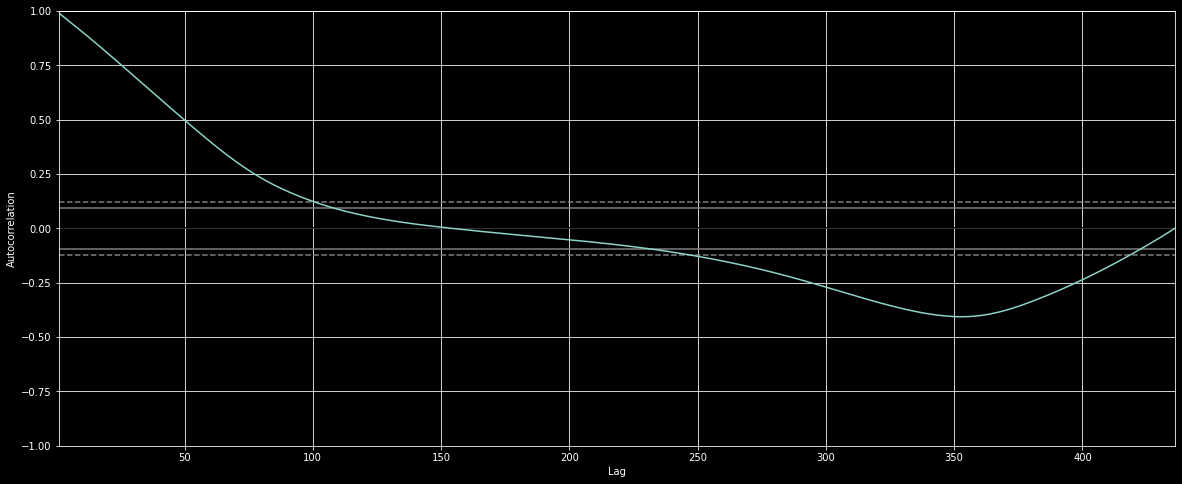

In [556]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(nyc_covid_df['case_rate'].tolist())

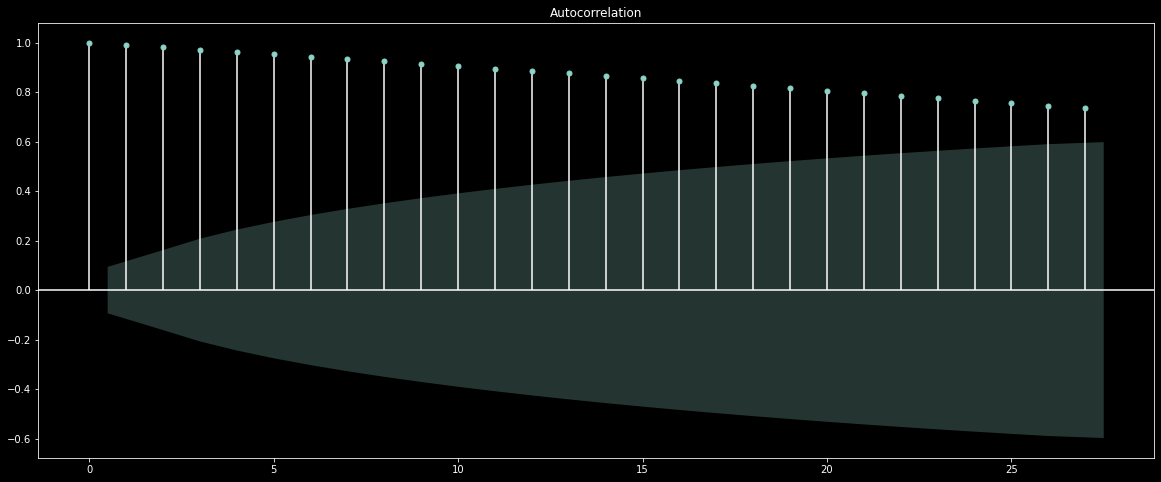

In [557]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(nyc_covid_df['case_rate'])
plt.show()

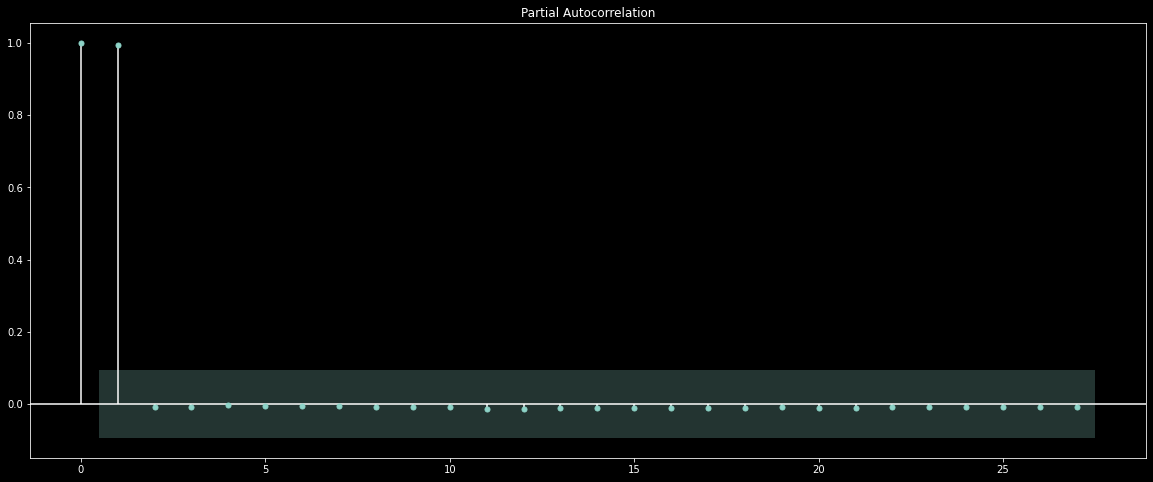

In [558]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(nyc_covid_df['case_rate'])
plt.show()

mean price and number of properties for rent autocorrelation plot:

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a ne

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

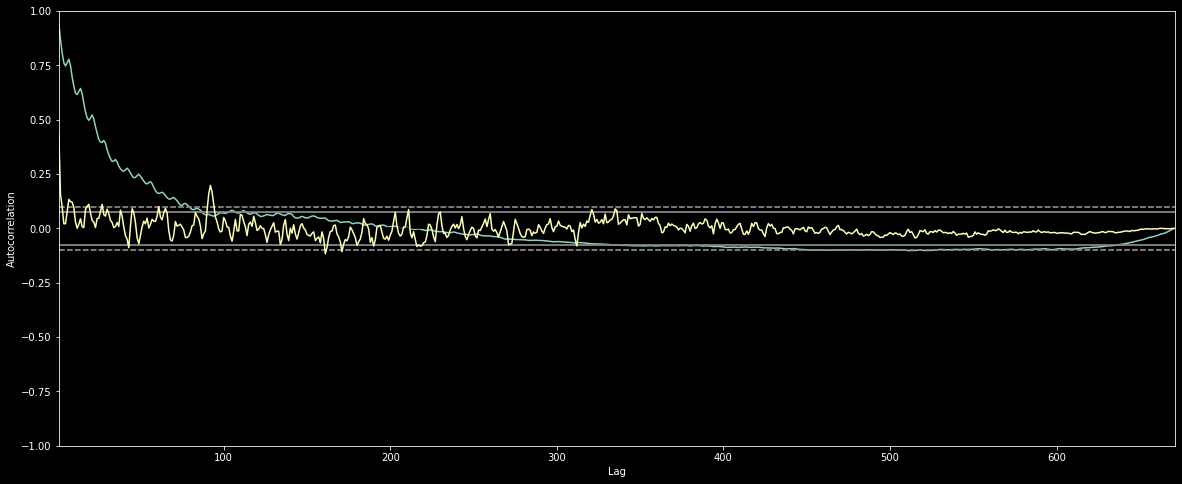

In [559]:
autocorrelation_plot(manhattan_ts['count'])
autocorrelation_plot(manhattan_ts['mean'])

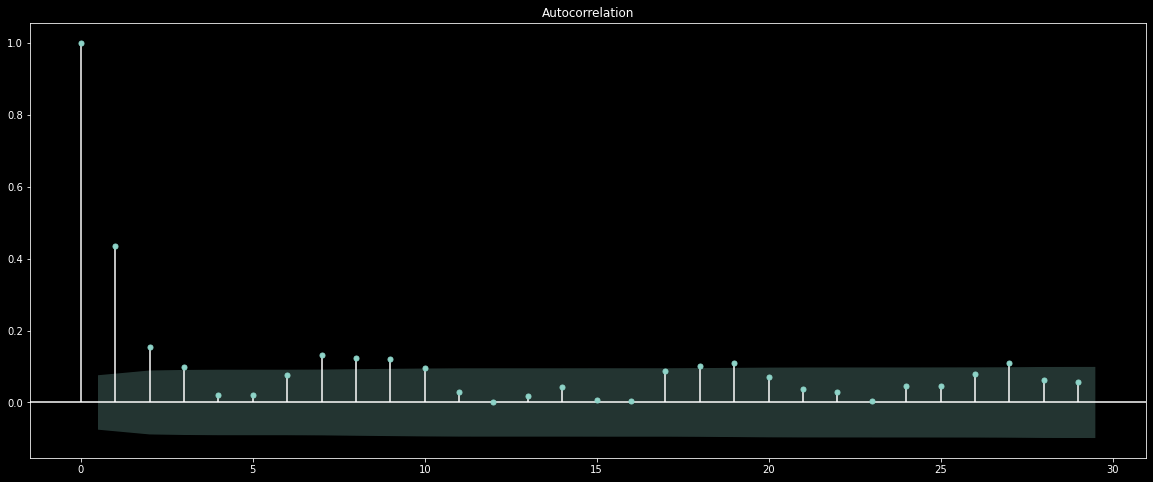

In [560]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(manhattan_ts['mean'])
plt.show()

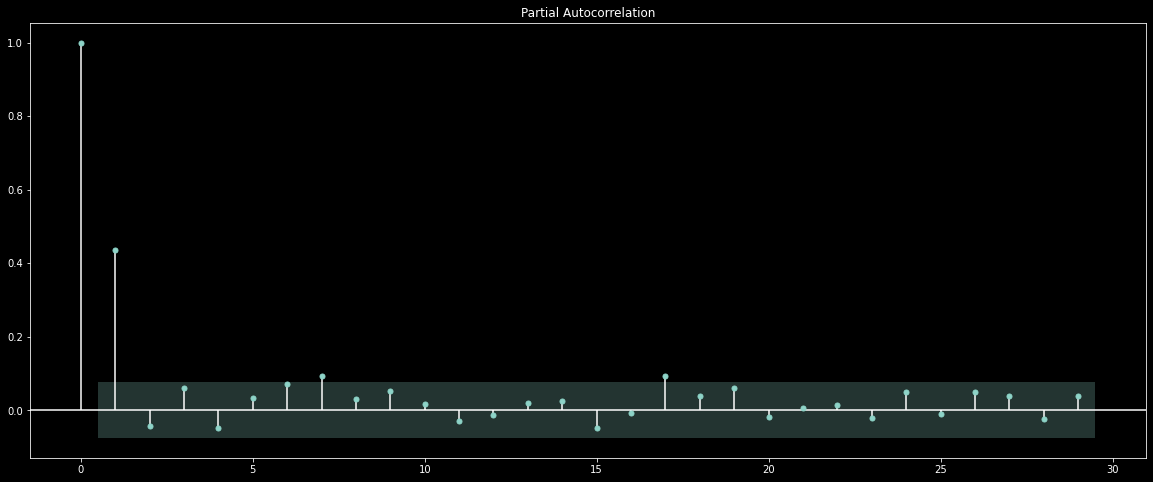

In [561]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(manhattan_ts['mean'])
plt.show()

# Cross Correlation

In [562]:
x = manhattan_ts['mean'][(manhattan_ts.index >= nyc_covid_df['new_case_rate'].index.min()) & (manhattan_ts.index <= nyc_covid_df['new_case_rate'].index.max())]
y = nyc_covid_df['new_case_rate']

y = y.replace(float("nan"), 0)
x = x.replace(float("nan"), 0)
x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)

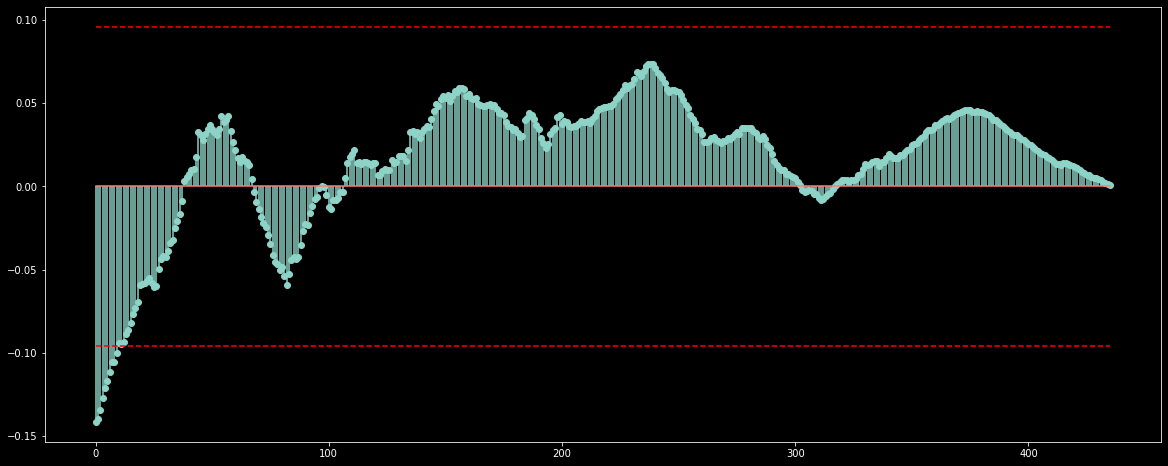

In [575]:
from statsmodels.tsa.stattools import ccf
from math import sqrt
cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

<StemContainer object of 3 artists>

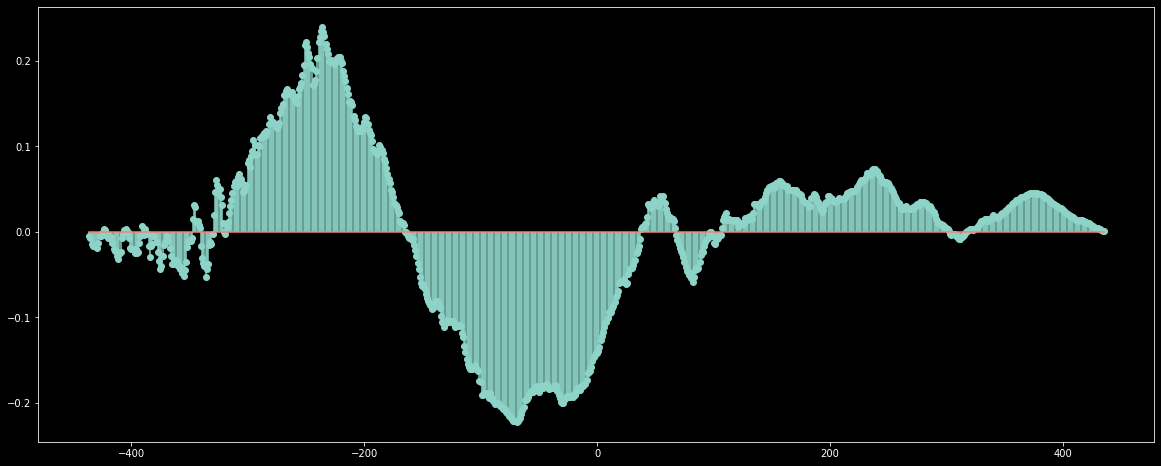

In [588]:
backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1]
forwards = ccf(x,y, adjusted=False)
ccf_output = np.r_[backwards, forwards]
plt.stem(list(range(-1*len(ccf_output)//2, len(ccf_output)//2)), ccf_output)

<StemContainer object of 3 artists>

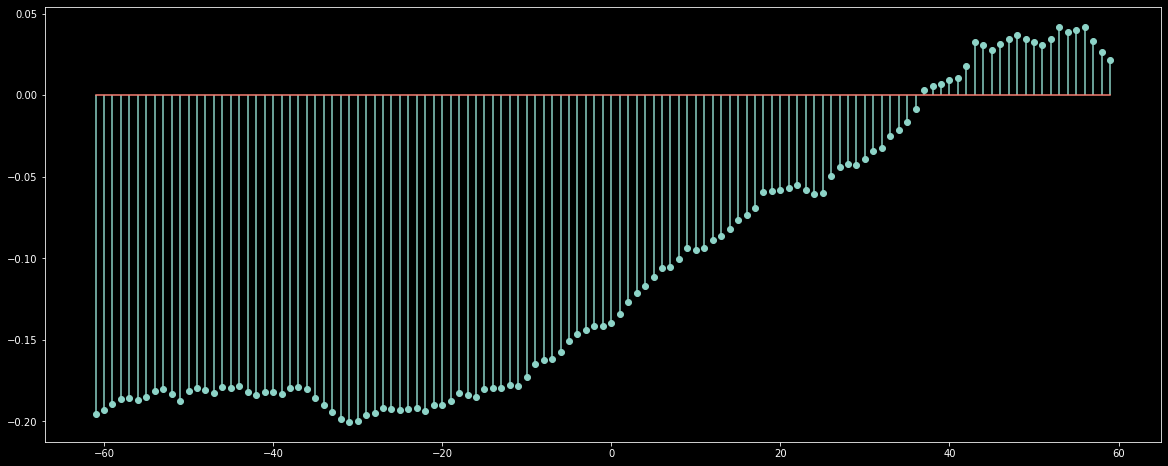

In [594]:
backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][-60:]
forwards = ccf(x,y, adjusted=False)[:61]
ccf_output = np.r_[backwards, forwards]
plt.stem(list(range(-1*len(ccf_output)//2, len(ccf_output)//2)), ccf_output)

In [564]:
df = pd.concat([x, y.shift(1)], axis=1)
df.corr()

,0,0
0,1.000000,-0.140212
0,-0.140212,1.000000


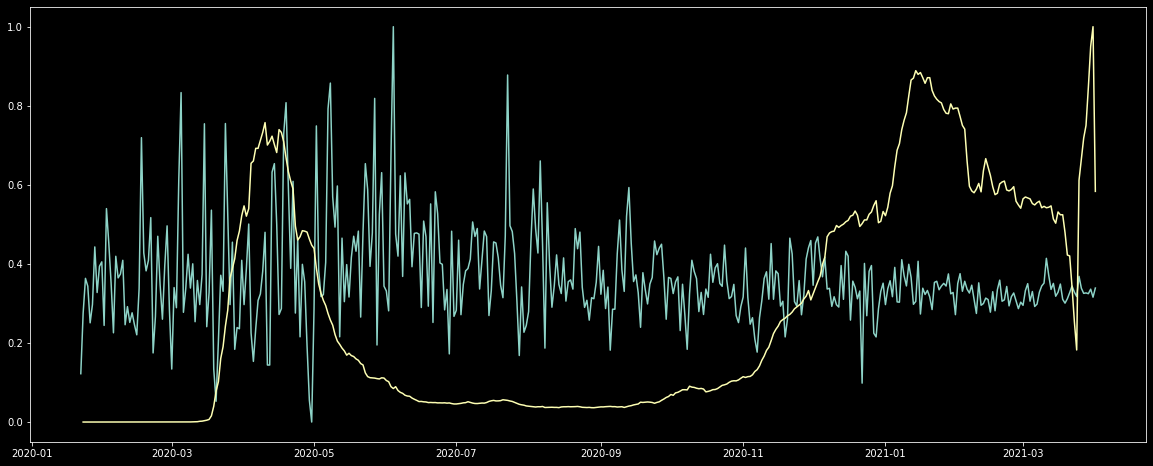

In [565]:
plt.plot(x)
plt.plot(y.shift(1))
plt.show()

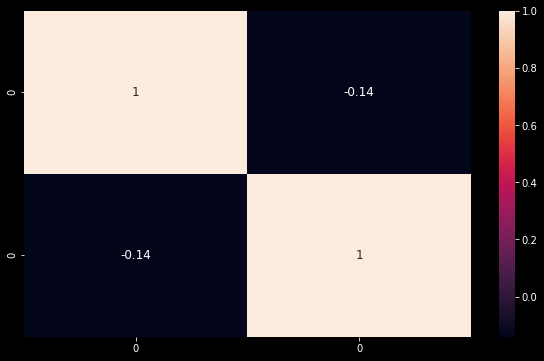

In [566]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [567]:
# TODO: remove seasonality and apply diff

I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process do not vary with time. 
There are five forms of stationary time-series data.

Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation. 


# Model Evaluation